In [1]:
import torch
from torch import nn
from dataset import load_data_wiki
from BERT import BERTModel
from d2l import torch as d2l



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Total training samples: 1648675
Selected subset samples: 16486
Processed paragraphs: 10589
Word counts: [('the', 59220), (',', 45092), ('.', 32606), ('of', 25571), ('and', 22775), ('in', 20196), ('to', 17737), ('a', 16004), ('=', 13237), ('"', 13202)]
len(vocab): 12729
Total paragraphs received: 10589
Total sentences after tokenization: 38761
Total examples for NSP: 22113
Total examples for MLM: 22113
Total token_ids: 22113
Total samples in train_set: 22113
torch.Size([64, 64]) torch.Size([64, 64]) torch.Size([64, 64]) torch.Size([64, 64]) torch.Size([64, 10]) torch.Size([64, 10]) torch.Size([64, 10]) torch.Size([64])


In [2]:
batch_size, max_len = 64, 64
train_iter, vocab = load_data_wiki(batch_size, max_len,data_dir=r'C:\Users\Administrator\.cache\huggingface\datasets\wikitext\wikitext-103-raw-v1\0.0.0\b08601e04326c79dfdd32d625aee71d232d685c3', subset_ratio=0.05)

print('len(vocab):',len(vocab))

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
           pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape, nsp_y.shape)
    break

Total training samples: 1648675
Selected subset samples: 82433
Processed paragraphs: 52980
Word counts: [('the', 287888), (',', 223046), ('.', 163372), ('of', 125057), ('and', 112459), ('in', 99545), ('to', 88791), ('a', 80016), ('=', 66492), ('"', 60996)]
len(vocab): 33335
Total paragraphs received: 52980
Total sentences after tokenization: 193400
Total examples for NSP: 110903
Total examples for MLM: 110903
Total token_ids: 110903
Total samples in train_set: 110903
len(vocab): 33335
torch.Size([64, 64]) torch.Size([64, 64]) torch.Size([64, 64]) torch.Size([64, 10]) torch.Size([64, 10]) torch.Size([64, 10]) torch.Size([64])


In [3]:
net = BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                num_layers=2, dropout=0.2, key_size=128, query_size=128,
                value_size=128, hid_in_features=128, mlm_in_features=128,
                nsp_in_features=128)

#devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
devices = [0] if torch.cuda.is_available() else ['cpu']  # 使用设备 ID 列表

loss = nn.CrossEntropyLoss()

In [4]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 前向传播
    #valid_lens_x = valid_lens_x.unsqueeze(1)  # 转换为 [batch_size, seq_len] 形状
    #print(f"valid_lens_x shape: {valid_lens_x.shape}")
    key_padding_mask = valid_lens_x != 0  # 假设 valid_lens_x 为有效长度，不等于 0 的部分是有效的 token

    # 交换 valid_lens_x 的维度，变成 [seq_len, batch_size]
    #valid_lens_x = valid_lens_x.transpose(0, 1)  # 变为 [64, 32]

    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x,
                                  pred_positions_X,
                                  key_padding_mask=key_padding_mask)
    # 计算遮蔽语言模型损失
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [5]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    # 确保 devices 是设备 ID 列表，而不是 torch.device 对象
    if isinstance(devices, torch.device):  # 如果 devices 是单个 torch.device 对象，转换成列表
        devices = [0]  # 获取设备 ID，假设它是 'cuda:0' 或 'cpu'
    
    # 将模型放到多个设备上，自动选择合适的设备（如果多个设备）
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])  # 将模型放到第一个设备
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss', xlim=[1, num_steps], legend=['mlm', 'nsp'])
    
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
            
            # 打印 token 和 segment 的最大值，确保它们没有超出词汇表大小
            print(f"vocab_size: {vocab_size}")

            print(f"Max token index: {tokens_X.max()}")
            print(f"Max segment index: {segments_X.max()}")
            # 打印 tokens 和 segments 的形状，确保它们是 [batch_size, seq_length]
            print(f"tokens shape: {tokens_X.shape}")
            print(f"segments shape: {segments_X.shape}")
            # 将数据传输到第一个设备，DataParallel 会处理数据分配
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            
            trainer.zero_grad()
            timer.start()
            
            # 计算每个 batch 的损失
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            
            # 反向传播和更新
            l.backward()
            trainer.step()
            
            # 更新度量值
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            
            # 更新可视化
            animator.add(step + 1, (metric[0] / metric[3], metric[1] / metric[3]))
            
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break
    
    # 打印最终的损失值和每秒处理的句子对数
    print(f'MLM loss {metric[0] / metric[3]:.3f}, 'f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on 'f'{str(devices)}')


MLM loss 4.937, NSP loss 0.736
4902.2 sentence pairs/sec on [0]


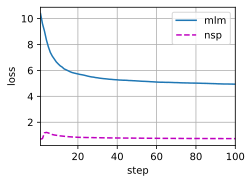

In [6]:
train_bert(train_iter, net, loss, len(vocab), devices, 100)